<h1 class="title toc-ignore" style="text-align: center;"><strong>Предсказание бросков Коби Брайанта</strong></h1>
<p><strong><img style="display: block; margin-left: auto; margin-right: auto;" src="http://i.imgur.com/xrOu1.png" alt="" /></strong></p>
<p style="text-align: center;"><em><strong>&ldquo;Все негативное &ndash; давление, вызовы &ndash; это возможность для меня подняться.&rdquo;</strong></em></p>
<p style="text-align: right;"><em><strong>Коби Брайант</strong></em></p>

# Вступление
<p style="text-align: justify;">Я большой поклонник баскетбола, и в этой статье мы проанализируем набор данных от Kaggle, содержащий позицию и обстоятельства каждого расстрела, в котором пытался забить Коби Брайант за свою 20-летнюю карьеру.</p>
<p style="text-align: justify; padding-left: 40px;"><strong>Коби Бин Брайант</strong> (родился 23 августа 1978 года) - американский бывший профессиональный баскетболист. Всю свою 20-летнюю карьеру он провел в составе "Лос-Анджелес Лейкерс" Национальной баскетбольной ассоциации (НБА). Он поступил в НБА прямо из средней школы и выиграл пять чемпионатов НБА с "Лейкерс". Брайант - 18-кратный чемпион всех звезд, 15-кратный член команды всех звезд НБА и 12-кратный член команды всех защитников. Он возглавлял НБА по забитым голам в течение двух сезонов и занимает третье место в лиге за все время регулярного сезона и четвертое место в списке забитых голов за все время после сезона. Он является рекордсменом НБА по количеству сезонов, проведенных с одной франшизой за всю карьеру, и широко известен как один из величайших баскетболистов всех времен. Брайант-первый защитник в истории НБА, сыгравший не менее 20 сезонов.</p>
<p style="text-align: justify;">Кстати, если вы любите баскетбол, вы также можете проверить эти другие ядра:</p>
<ul>
<li style="text-align: justify;"><a href="https://www.kaggle.com/xvivancos/michael-jordan-vs-kobe-bryant-vs-lebron-james">Michael Jordan vs Kobe Bryant vs Lebron James</a></li>
<li style="text-align: justify;"><a href="https://www.kaggle.com/xvivancos/eda-tweets-during-cavaliers-vs-warriors">EDA - Tweets during Cavaliers vs Warriors</a></li>
<li style="text-align: justify;"><a href="https://www.kaggle.com/xvivancos/how-good-is-luka-doncic">How good is Luka Doncic?</a></li></ul>
<h3><strong>Объявим необходимые библиотеки для дальнейшей работы:</strong></h3>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn import mixture
from sklearn import ensemble
from sklearn import model_selection
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import log_loss
import time
import itertools
import operator

<h4><strong>Загрузим данные и создадим несколько полезных полей</strong></h4>
<p>Показываем вновь созданные поля в качестве проверки на вменяемость.</p>

In [10]:
# Загрузка тренировочных данных
allData = pd.read_csv('..\Kobe_Bryant\input\data.csv')
data = allData[allData['shot_made_flag'].notnull()].reset_index()

# Добавляем несколько временных столбцов к данным
data['game_date_DT'] = pd.to_datetime(data['game_date'])
data['dayOfWeek']    = data['game_date_DT'].dt.dayofweek
data['dayOfYear']    = data['game_date_DT'].dt.dayofyear

data['secondsFromPeriodEnd']   = 60*data['minutes_remaining']+data['seconds_remaining']
data['secondsFromPeriodStart'] = 60*(11-data['minutes_remaining'])+(60-data['seconds_remaining'])
data['secondsFromGameStart']   = (data['period'] <= 4).astype(int) * (data['period'] - 1) * 12 * 60 + (data['period'] > 4).astype(int) * ((data['period'] - 4) * 5 * 60 + 3 * 12 * 60) + data['secondsFromPeriodStart']

# Посмотрим на первые пару рядов и убедимся, что все хорошо
data.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


<h4><strong>Построение графика попыток выстрела как функции времени во время игры&nbsp;</strong></h4>
<p>Здесь мы применяем 3 различных разбиения времени и показываем попытки бросков как гистограмму от начала игры</p>

Text(0.5, 0, 'Время [Секунды от начала игры]')

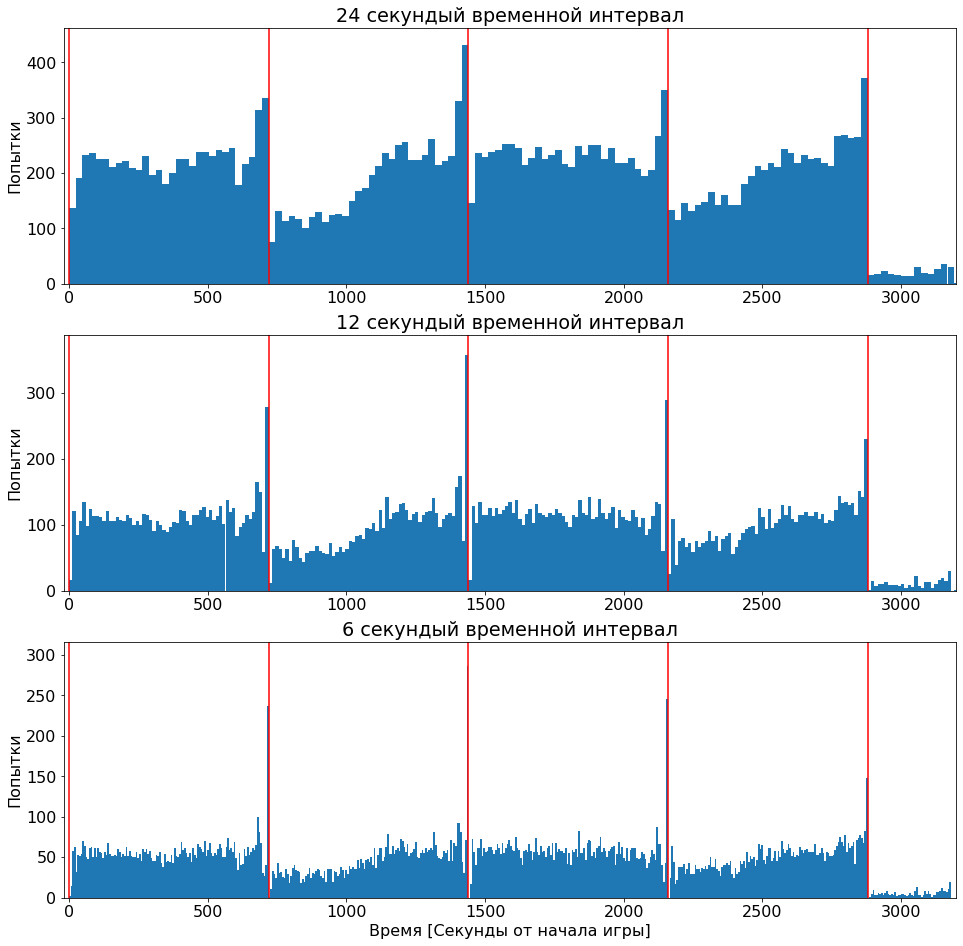

In [24]:
# Строим гистограмму попыток бросков в зависимости от времени (от начала игры) с несколькими разбиениями
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

binsSizes = [24,12,6]

plt.figure();
for k, binSizeInSeconds in enumerate(binsSizes):
    timeBins = np.arange(0,60 * (4 * 12 + 3*5), binSizeInSeconds) + 0.01
    attemptsAsFunctionOfTime, b = np.histogram(data['secondsFromGameStart'], bins = timeBins)     
    
    maxHeight = max(attemptsAsFunctionOfTime) + 30
    barWidth = 0.999 * (timeBins[1] - timeBins[0])
    
    plt.subplot(len(binsSizes), 1, k + 1)
    plt.bar(timeBins[:-1], attemptsAsFunctionOfTime, align='edge', width=barWidth)
    plt.title(str(binSizeInSeconds) + ' секундый временной интервал')
    
    plt.vlines(x = [0, 12*60, 2*12*60, 3*12*60, 4*12*60], ymin = 0, ymax = maxHeight, colors = 'r')
    
    plt.xlim((-20,3200))
    plt.ylim((0,maxHeight))
    
    plt.ylabel('Попытки')
    
plt.xlabel('Время [Секунды от начала игры]')

<blockquote>
<p><em>Похоже, что Кобе доверяют делать последний выстрел в каждом периоде, а можно заметить, что он обычно находится на скамейке запасных в начале 2-ой и 4-ой четверти.</em></p>
</blockquote>

<h4><strong>Отображение точности выстрела как функции времени во время игры&nbsp;</strong></h4>

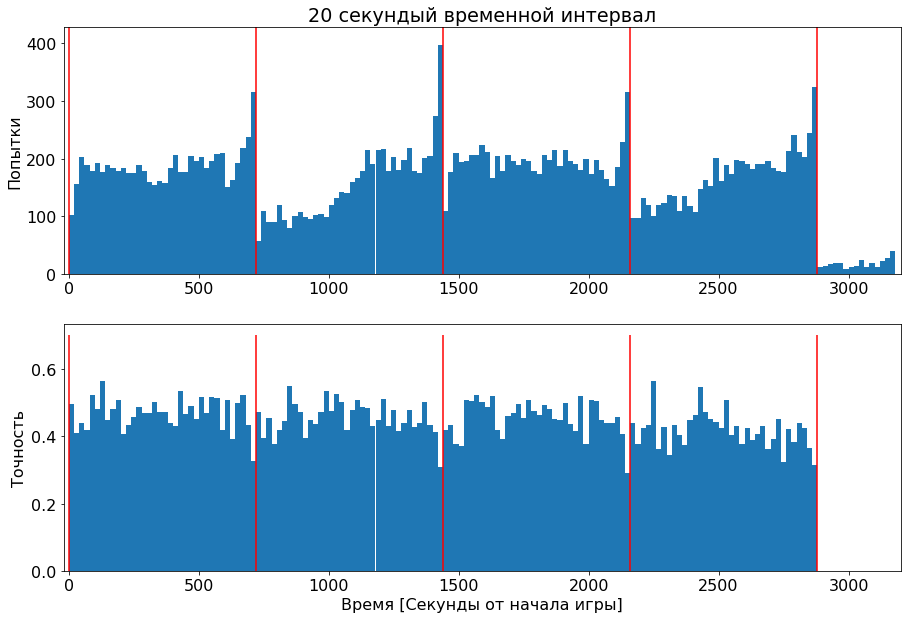

In [34]:
# Построим отображение точности как функции времени
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 16

binSizeInSeconds = 20
timeBins = np.arange(0,60 * (4*12 + 3*5),binSizeInSeconds) + 0.01
attemptsAsFunctionOfTime,     b = np.histogram(data['secondsFromGameStart'], bins = timeBins)     
madeAttemptsAsFunctionOfTime, b = np.histogram(data.loc[data['shot_made_flag'] == 1,'secondsFromGameStart'], bins=timeBins)     
attemptsAsFunctionOfTime[attemptsAsFunctionOfTime < 1] = 1
accuracyAsFunctionOfTime = madeAttemptsAsFunctionOfTime.astype(float) / attemptsAsFunctionOfTime
accuracyAsFunctionOfTime[attemptsAsFunctionOfTime <= 50] = 0 # Нулевая точность интервалов, в которых недостаточно данных

maxHeight = max(attemptsAsFunctionOfTime) + 30
barWidth = 0.999 * (timeBins[1] - timeBins[0])

plt.figure()
plt.subplot(2,1,1)
plt.bar(timeBins[:-1],attemptsAsFunctionOfTime, align='edge', width=barWidth)
plt.xlim((-20,3200))
plt.ylim((0,maxHeight)); plt.ylabel('Попытки')
plt.title(str(binSizeInSeconds) + ' секундый временной интервал')
plt.vlines(x = [0, 12*60, 2*12*60, 3*12*60, 4*12*60], ymin = 0, ymax = maxHeight, colors = 'r')
plt.subplot(2,1,2)
plt.bar(timeBins[:-1],accuracyAsFunctionOfTime, align='edge', width=barWidth)
plt.xlim((-20,3200))
plt.ylabel('Точность')
plt.xlabel('Время [Секунды от начала игры]')
plt.vlines(x=[0, 12*60, 2*12*60, 3*12*60, 4*12*60], ymin = 0.0,ymax = 0.7, colors='r')

<blockquote>
<p><em>Обратите внимание, что точность бросков "в последнюю секунду" неизменно ниже, чем обычно. Это можно связанать с тем, что большое количество этих бросков сделаны за линение 3 очковой дуги.</em></p>
</blockquote>

<h3>Теперь продолжим наше первоначальное исследование и рассмотрим аспект пространственного расположения бросков Кобе</h3>
<p>Мы сделаем это, построив гауссовскую модель смеси, которая пытается компактно резюмировать места выстрелов Кобе</p>

In [36]:
# Группа попыток бросков Кобе, используя "Обобщённый метод моментов" на их месте
numGaussians = 13
gaussianMixtureModel = mixture.GaussianMixture(n_components=numGaussians, covariance_type='full', 
                                               init_params='kmeans', n_init=50, 
                                               verbose=0, random_state=5)
gaussianMixtureModel.fit(data.loc[:,['loc_x','loc_y']])

# add the GMM cluster as a field in the dataset
data['shotLocationCluster'] = gaussianMixtureModel.predict(data.loc[:,['loc_x','loc_y']])

<h4>Определите некоторые вспомогательные функции</h4>
<p>функция draw_court() бесстыдно украдена из превосходного скрипта Михаэля Крюгера)</p>

In [38]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # Если объект axes не предусмотрен для построения графика, просто получите текущий
    if ax is None:
        ax = plt.gca()

    # Создайте различных частей баскетбольной площадки НБА

    # Создание баскетбольного кольцо
    
    # Диаметр обруча составляет 18 дюймов, поэтому он имеет радиус 9 дюймов, 
    # что является значением 7.5 в нашей системе координат
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Сощдание баскетбольного щита
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Отрисовка
    
    # Создание внещней коробки, шириной = 16ft, высотой = 19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    
    # Создание внутренней коробки, шириной = 12ft, высотой = 19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Создание верхней дуги штрафного броска
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    
    # Создание нижней дуги штрафного броска
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    
    # Зона ограниченного доступа, это дуга радиусом 4 фута от центра обруча.
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Трехочковая линия
    # Создайте трехочковой линии, она имет длину 14 футов.
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    
    # Трехочковая дуга - центром дуги будет обруч, сама дуга находится на расстоянии 23 футов 9 дюймов от обруча
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Центральный корт
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # Перечень элементов площадки для нанесения на оси
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Отрисовка центарльной, базовой и боковой линии 
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Добавьление элементы площадки на оси
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        
        # Получить собственные векторы и собственные значения ковариационной матрицы
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # Переход к единицам стандартного отклонения вместо дисперсии
        
        # Вычисление уголов эллипса и длин двух осей и их отрисовка
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # Конвертиртация в градусы
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

<h4>Отрисовка двумерных гауссиан попыток бросков</h4>
<p>Каждый эллипс - это контур, который представляет собой 2,5 стандартных отклонения от центра гауссианы. Каждое число синего цвета представляет процент бросков, сделанных с помощью этого гауссиана, от всех бросков.</p>

Text(0.5, 1.0, 'Броски')

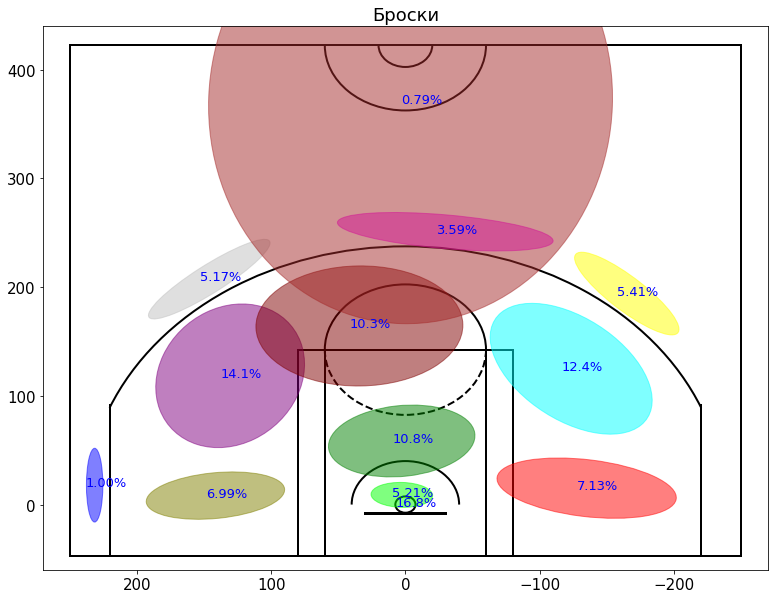

In [40]:
# Отображение эллипсов гауссовой смеси попыток бросков
plt.rcParams['figure.figsize'] = (13, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4]+'%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)
draw_court(outer_lines=True); plt.ylim(-60,440); plt.xlim(270,-270)
plt.title('Броски')

<blockquote>
<p>Мы видим, что Коби делает больше попыток с <strong>левой стороны</strong> поля(или с <strong>правой стороны</strong>, с его точки зрения). Это вероятно потому, что он <strong>правша</strong>.</p>
<p>Также мы видим, что огромное количество попыток (16,8%) происходит непосредственно из-под корзины, а 5,06% дополнительных попыток - из очень близких к корзине.</p>
</blockquote>